In [ ]:
 from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal
from scipy.signal import savgol_filter
from  scipy import ndimage
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize 
from scipy.ndimage.filters import uniform_filter1d

from numpy import expand_dims , zeros,ones,asarray
from numpy.random import randn,randint

import tensorflow 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model
from scipy.ndimage.filters import uniform_filter1d, gaussian_filter
from tensorflow.keras.layers import Input,Dense,Reshape,Flatten,Conv1D,\
                         Conv1DTranspose,LeakyReLU,Dropout,\
                         Lambda,Activation,MaxPooling1D,BatchNormalization,\
                         Embedding,Concatenate
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras import backend
import pandas as pd
import numpy as np
from inspect import signature
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            confusion_matrix, fbeta_score, precision_recall_curve, \
                            average_precision_score, auc
tf.test.gpu_device_name()
!nvidia-smi

from numpy.random import seed
seed(0)
tensorflow.random.set_seed(0)

P_OUTLIERS = 2
FILTER_NUMBER = 1
TIPO_NORM = 1

Wed Dec 29 18:58:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    59W / 149W |    145MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def fourier_transform(df):
    df_fft = np.abs(np.fft.fft(df, axis=1))
    return df_fft

def reduce_upper_outliers(df,reduce = 0.01, half_width=4):
    length = len(df.iloc[0,:])
    remove = int(length*reduce)
    for i in df.index.values: 
        values = df.loc[i,:]
        sorted_values = values.sort_values(ascending = False)
        for j in range(remove): 
            idx = sorted_values.index[j]
            new_val = 0
            count = 0
            idx_num = int(idx[5:])
            for k in range(2*half_width+1):
                idx2 = idx_num + k - half_width
                if idx2 <1 or idx2 >= length or idx_num == idx2:
                    continue
                new_val += values['FLUX.'+str(idx2)]

                count += 1
            new_val /= count 
            if new_val < values[idx]: 
                df.at[i,idx] = new_val
    return df

def iterar_ruo(df, n=2):
    for i in range(n): 
        df2 = reduce_upper_outliers(df)
    return df2

def apply_filter(df,filternumber):
    
    if filternumber == 0:
        filt = uniform_filter1d(df, axis=1, size=50)
    
    elif filternumber == 1:
        filt = ndimage.filters.gaussian_filter(df, sigma=10)
    
    elif filternumber == 2:
        filt = savgol_filter(df,21,4,deriv=0)

    return filt


def apply_normalization(df_train, df_test, nnumber):
  
    if nnumber == 0:
        scaler = MinMaxScaler()
        norm_train = scaler.fit_transform(df_train)
        norm_test = scaler.transform(df_test)
    
    elif nnumber == 1:
        norm_train = normalize(df_train)
        norm_test = normalize(df_test)
  
    elif nnumber == 2:
        scaler = RobustScaler()
        norm_train = scaler.fit_transform(df_train)
        norm_test = scaler.transform(df_test)
        
    
    norm_train = pd.DataFrame(norm_train)
    norm_test = pd.DataFrame(norm_test)
    return norm_train, norm_test


def apply_standarization(df_train, df_test):
    scaler = StandardScaler()
    norm_train = scaler.fit_transform(df_train)
    norm_test = scaler.transform(df_test)
    
    norm_train = pd.DataFrame(norm_train)
    norm_test = pd.DataFrame(norm_test)
    return norm_train, norm_test

In [ ]:
class dataProcessor:

    def __init__(self, outlier=False, smoothing=False, fourier=False, normalize=False, standardize=False):
        self.outlier = outlier
        self.smoothing = smoothing
        self.normalize = normalize
        self.standardize = standardize
        self.fourier = fourier
    
    def process(self, df_train_x, df_test_x):
                
        if self.outlier:
            print("Removing upper outliers...")
            df_train_x = iterar_ruo(df_train_x, P_OUTLIERS)
            df_test_x = iterar_ruo(df_test_x, P_OUTLIERS)
            
        
        if self.fourier:
            print("Applying Fourier...")
            df_train_x = fourier_transform(df_train_x)
            df_test_x = fourier_transform(df_test_x)
        
        
        if self.smoothing:
            print("Applying smoothing filter...")
            df_train_x = pd.DataFrame(apply_filter(df_train_x, FILTER_NUMBER ))
            df_test_x = pd.DataFrame(apply_filter(df_test_x, FILTER_NUMBER ))
            
      
        if self.normalize:
            print("Normalizing...")
            df_train_x, df_test_x = apply_normalization(df_train_x, df_test_x, TIPO_NORM )
            
      
        if self.standardize:
            print("Standardizing...")
            df_train_x, df_test_x = apply_standarization(df_train_x, df_test_x)
        

        print("Finished Processing!")
        return df_train_x, df_test_x

In [ ]:
def load_real_samples():

  print("Loading datasets...")
  train = pd.read_csv("/content/gdrive/My Drive/exoTrain.csv", encoding= "ISO-8859-1") 
  test = pd.read_csv("/content/gdrive/My Drive/exoTest.csv", encoding= "ISO-8859-1") 
  x_train = train.drop('LABEL', axis=1)
  x_test = test.drop('LABEL', axis=1)
  y_train = train.LABEL
  y_test = test.LABEL

  Processor = dataProcessor(outlier = True,fourier = True,smoothing = True,normalize= True,standardize= True)

  df_train_x = x_train.copy()
  df_test_x = x_test.copy()
  df_train_x, df_test_x = Processor.process(df_train_x, df_test_x)

  df_train_x = np.array(df_train_x)
  y_train = np.array(y_train).reshape((-1,1))-1
  df_test_x = np.array(df_test_x)
  y_test = np.array(y_test).reshape((-1,1))-1

  df_train_x = np.append(df_train_x, np.flip(df_train_x[0:37,:], axis=-1), axis=0)
  y_train = np.append(y_train, y_train[0:37]) 
  df_test_x = np.append(df_test_x, np.flip(df_test_x[0:5,:], axis=-1), axis=0)
  y_test = np.append(y_test, y_test[0:5])


  print("df_test_x shape is ",df_test_x.shape)
  print("df_train_x shape is ",df_train_x.shape)
  print("y_train shape is ",y_train.shape)
  print("y_test shape is",y_test.shape)

  return [df_train_x ,y_train],[df_test_x,y_test]

In [ ]:
def define_generator(latent_dim, n_classes=2):

  init = RandomNormal(stddev=0.02)
    
  in_label = Input(shape=(1,))

  li = Embedding(n_classes, 10)(in_label)

  n_nodes = 500 * 1
  li = Dense(n_nodes, kernel_initializer=init)(li)
  li = Reshape((500 , 1))(li)
    
  in_lat = Input(shape=(latent_dim,))
    
  n_nodes = 500
  gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
  gen = Activation('relu')(gen)
  gen = Reshape((500 , 1))(gen)
  merge = Concatenate()([gen, li])

  gen = Conv1DTranspose(128, 7, strides= 2, padding='same', use_bias=False, kernel_initializer=init,kernel_regularizer='l2')(merge)
  gen = BatchNormalization()(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Flatten()(gen)

  gen = Dense(1065, kernel_initializer=init, use_bias=False,kernel_regularizer='l2')(gen)
  gen = BatchNormalization()(gen)
  gen = LeakyReLU(alpha=0.2)(gen)

  gen = Dense(1598, kernel_initializer=init, use_bias=False,kernel_regularizer='l2')(gen)
  gen = BatchNormalization()(gen)
  gen = LeakyReLU(alpha=0.2)(gen)

  gen = Dense(3197, kernel_initializer=init)(gen)
  gen = Reshape((3197 , 1))(gen)

  out_layer = Activation('tanh')(gen)
    
  model = Model([in_lat, in_label], out_layer)
  return model 

In [ ]:
  def define_discriminator(in_shape=(3197,1), n_classes=2):
    
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=in_shape)
    
    fe = Conv1D(filters = 32 ,kernel_size = 7 , strides = 2, padding='same')(in_image)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Conv1D(filters = 64 ,kernel_size = 7 , strides = 2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Conv1D(filters = 128,kernel_size = 7 , strides = 2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Conv1D(filters = 128,kernel_size = 7 , strides = 2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Conv1D(filters = 128,kernel_size = 7 , strides= 2 , padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Dropout(.8)(fe)
    
    fe = Flatten()(fe)
    
    out1 = Dense(1, activation='sigmoid')(fe)
    
    out2 = Dense(n_classes, activation='softmax')(fe)
    
    model = Model(in_image, [out1, out2])
    
    opt = Adam(learning_rate=4e-5, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)

    return model

In [ ]:
def define_gan(g_model, d_model):
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	
	gan_output = d_model(g_model.output)
	
	model = Model(g_model.input, gan_output)
	
	opt = Adam(learning_rate=4e-6, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

In [ ]:
def generate_real_samples(dataset, n_samples):
	
	images, labels = dataset
	
	ix = randint(0, images.shape[0], n_samples)
	
	X, labels = images[ix], labels[ix]
	
	y = ones((n_samples, 1))
 
	return [X, labels], y
 
def generate_latent_points(latent_dim, n_samples, n_classes=2):

  x_input = randn( n_samples * latent_dim )
    
  z_input = x_input.reshape(n_samples , latent_dim)

  labels = randint(0, n_classes, n_samples)

  return [z_input, labels]
 
def generate_fake_samples(generator, latent_dim, n_samples):
	
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)

	images = generator.predict([z_input, labels_input])

	y = zeros((n_samples, 1))
 
	return [images, labels_input], y

In [ ]:
def summarize_performance(step, g_model,d_model, latent_dim, dataset ,n_samples=100):
	 
  [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    
  X = (X + 1) / 2.0
    
  #for i in range(100):
      
  #	pyplot.subplot(10, 10, 1 + i)
      
  #	pyplot.axis('off')
      
  #	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
  
  #filename1 = 'generated_plot_%04d.png' % (step+1)
  #pyplot.savefig(filename1)
  #pyplot.close()
     
  #filename2 = 'model_%04d.h5' % (step+1)
  #g_model.save(filename2)
  #print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
def train(g_model, d_model, gan_model, dataset, data , latent_dim , n_epochs=20, n_batch=32):
	
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
      
  x_,y_ = data
        
  n_steps = bat_per_epo * n_epochs
        
  half_batch = int(n_batch / 2)
        
  for i in range(n_steps):
    
    [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            
    _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
            
    [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            
    _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
            
    [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
            
    y_gan = ones((n_batch, 1))
            
    _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        
    print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
            
    if (i+1) % (bat_per_epo * 10) == 0:
      summarize_performance(i, g_model,d_model, latent_dim, dataset)

  return d_model , gan_model

In [ ]:
dataset ,data = load_real_samples()

Loading datasets...
Removing upper outliers...


In [ ]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
d_model , gan_model = train(generator, discriminator, gan_model, dataset, data , latent_dim)

>1, dr[1.128,1.494], df[1.037,0.680], g[0.943,1.157]
>2, dr[0.832,1.588], df[1.032,0.980], g[0.917,1.094]
>3, dr[0.870,1.901], df[0.787,1.126], g[0.980,1.042]
>4, dr[0.742,0.833], df[0.823,1.115], g[1.164,1.483]
>5, dr[0.973,1.256], df[0.760,1.378], g[0.935,0.845]
>6, dr[0.817,0.588], df[0.626,0.691], g[1.154,1.041]
>7, dr[1.231,0.386], df[0.609,0.874], g[1.119,1.492]
>8, dr[0.804,0.618], df[0.557,0.955], g[0.887,0.886]
>9, dr[0.940,0.535], df[0.393,1.218], g[0.856,1.093]
>10, dr[0.857,0.663], df[0.722,0.903], g[1.178,1.297]
>11, dr[0.802,0.570], df[0.391,1.520], g[0.950,0.849]
>12, dr[0.867,0.436], df[0.330,0.719], g[0.901,1.094]
>13, dr[0.679,0.668], df[0.405,0.973], g[1.077,1.092]
>14, dr[0.683,0.413], df[0.269,1.215], g[1.132,1.084]
>15, dr[0.854,0.615], df[0.140,1.002], g[0.805,1.357]
>16, dr[0.622,0.469], df[0.122,1.189], g[0.966,1.267]
>17, dr[0.568,0.274], df[0.193,0.478], g[1.197,1.367]
>18, dr[0.675,0.471], df[0.196,0.903], g[0.775,0.876]
>19, dr[0.680,0.270], df[0.112,0.875]

In [ ]:
d_model.evaluate(data[0] , data[1] ,verbose = 2)
d_model.evaluate(dataset[0],dataset[1],verbose = 2)

18/18 - 1s - loss: 0.9207 - dense_loss: 0.7196 - dense_1_loss: 0.2011 - 653ms/epoch - 36ms/step
161/161 - 2s - loss: 0.4454 - dense_loss: 0.1895 - dense_1_loss: 0.2559 - 2s/epoch - 11ms/step


[0.4454224705696106, 0.18950432538986206, 0.25591811537742615]

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            confusion_matrix, fbeta_score, precision_recall_curve,\
                            auc,classification_report

def shuffle_in_unison(a, b):
  rng_state = np.random.get_state()
  np.random.shuffle(a)
  np.random.set_state(rng_state)
  np.random.shuffle(b)

def model_evaluation(Y , Y_pred):

  pred = np.empty((1,len(Y_pred)), dtype=object)
  pred = np.where(Y_pred>=0.77, 1, 0)
  Y = np.reshape(Y,len(Y))
  pred = np.reshape(pred,len(pred))

  print("________________________________________________________________Classification report:__________________________________________________________________")
  print("--------------------------------------------------------------------------------------------------------------------------------------------------------")
  print(classification_report(Y ,pred))

  accuracy = accuracy_score(Y, pred)
  precision = precision_score(Y , pred)
  recall = recall_score(Y, pred)
  fbeta = fbeta_score(Y, pred, 1)
  print('Accuracy: %.3f Precision: %.3f Recall: %.3f F_beta: %.3f'% (accuracy, precision, recall, fbeta))

  print("################################################################__confusion matrix__#######################################################################")
  print("-----------------------------------------------------------------------------------------------------------------------------------------------------------")
  conf_matrix = pd.crosstab(Y, pred)
  print(conf_matrix)
  matrix = confusion_matrix(Y, pred)
  DF_CM = pd.DataFrame(matrix, columns=np.unique(Y), index = np.unique(Y))
  DF_CM.index.name = 'Actual'
  DF_CM.columns.name = 'Predicted'
  plt.figure(figsize = (5,5))
  sn.set(font_scale=1.4) 
  sn.heatmap(DF_CM, cmap="PuRd", annot=True , annot_kws={"size": 10})
  TN = matrix[0][0]
  FP = matrix[0][1]
  FN = matrix[1][0]
  TP = matrix[1][1]

  print("**********************************************************__PR-CURVE and Area Under PR-CURVE_************************************************************")
  print("---------------------------------------------------------------------------------------------------------------------------------------------------------")
  precision, recall, _ = precision_recall_curve(Y, Y_pred)
  auc_pr = auc(recall, precision)
  print("AREA UNDER THE CURVE",auc_pr)
  plt.figure(figsize=[5,5])
  plt.fill_between(recall, precision, alpha=.5)
  plt.ylabel("Precision")
  plt.xlabel("Recall")
  plt.title("Precision-Recall curve");

################################################################__confusion matrix__#######################################################################
-----------------------------------------------------------------------------------------------------------------------------------------------------------
col_0     0   1
row_0          
0      5042   8
1         0  74
Predicted         0         1
Actual                       
0          0.998416  0.001584
1          0.000000  1.000000
________________________________________________________________Classification report:__________________________________________________________________
--------------------------------------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5050
           1       0.90      1.00      0.95        74

    accuracy                      

TypeError: ignored

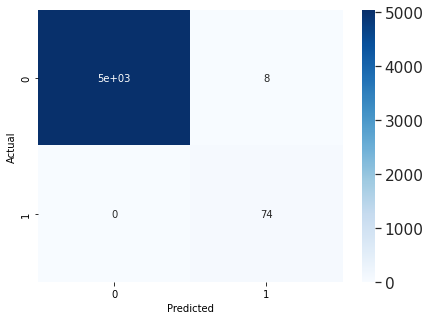

In [ ]:
shuffle_in_unison(dataset[0],dataset[1])
y_pred = d_model.predict(dataset[0])
model_evaluation(dataset[1] , y_pred[1][:][:,1])

################################################################__confusion matrix__#######################################################################
-----------------------------------------------------------------------------------------------------------------------------------------------------------
col_0    0
row_0     
0      565
1       10
Predicted    0    1
Actual             
0          1.0  0.0
1          1.0  0.0
________________________________________________________________Classification report:__________________________________________________________________
--------------------------------------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       565
           1       0.00      0.00      0.00        10

    accuracy                           0.98       575
   macro avg       0.49      0.50      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

TypeError: ignored

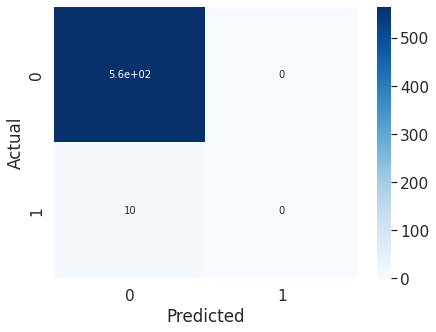

In [ ]:
shuffle_in_unison(data[0],data[1])
y_pred = d_model.predict(data[0])
model_evaluation(data[1] , y_pred[1][:][:,1])

In [ ]:
from tensorflow.keras.models import Model , load_model , model_from_json

In [ ]:
model_json = gan_model.to_json()
with open("/content/gdrive/My Drive/ACGAN_model/gan_model_9.json", "w") as  json_file:
  json_file.write(model_json)
gan_model.save_weights("/content/gdrive/My Drive/ACGAN_model/gan_model_9.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
json_file = open('/content/gdrive/My Drive/ACGAN_model/gan_model_9.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/gdrive/My Drive/ACGAN_model/gan_model_9.h5") 
print("Loaded model from disk")
loaded_model.summary()

Loaded model from disk
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 500)          50500       input_3[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        20          input_2[0][0]                    
_____________________________________________________________________

In [ ]:
model_json = d_model.to_json()
with open("/content/gdrive/My Drive/ACGAN_model/d_model_9.json", "w") as  json_file:
  json_file.write(model_json)
d_model.save_weights("/content/gdrive/My Drive/ACGAN_model/d_model_9.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
json_file = open('/content/gdrive/My Drive/ACGAN_model/d_model_9.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/gdrive/My Drive/ACGAN_model/d_model_9.h5") 
print("Loaded model from disk")
loaded_model.summary()

Loaded model from disk
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3197, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1599, 32)     256         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1599, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1599, 32)     0           batch_normalization[0][0]        
_______________________________________________________________________

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            confusion_matrix, fbeta_score, precision_recall_curve,\
                            auc,classification_report

def shuffle_in_unison(a, b):
  rng_state = np.random.get_state()
  np.random.shuffle(a)
  np.random.set_state(rng_state)
  np.random.shuffle(b)

def model_evaluation(Y , Y_pred):

  pred = np.empty((1,len(Y_pred)), dtype=object)
  pred = np.where(Y_pred>=.77, 1, 0)
  Y = np.reshape(Y,len(Y))
  pred = np.reshape(pred,len(pred))

  print("################################################################__confusion matrix__#######################################################################")
  print("-----------------------------------------------------------------------------------------------------------------------------------------------------------")

  conf_matrix = pd.crosstab(Y, pred)
  print(conf_matrix)

  matrix = confusion_matrix(Y, pred)
  DF_CM = pd.DataFrame(matrix, columns=np.unique(Y), index = np.unique(Y))
  DF_CM.index.name = 'Actual'
  DF_CM.columns.name = 'Predicted'
  plt.figure(figsize = (15,5))
  plt.subplot(1,2,1)
  sn.set(font_scale=1.4) 
  sn.heatmap(DF_CM , annot=True , cmap='Blues',annot_kws={"size": 10})
  TN = matrix[0][0]
  FP = matrix[0][1]
  FN = matrix[1][0]
  TP = matrix[1][1]

  row_total = DF_CM.sum(axis=1)
  DF_CM[0:1] = DF_CM[0:1]/row_total[0]
  DF_CM[1:] = DF_CM[1:]/row_total[1]
  print(DF_CM)

  print("________________________________________________________________Classification report:__________________________________________________________________")
  print("--------------------------------------------------------------------------------------------------------------------------------------------------------")
  print(classification_report(Y ,pred))

  accuracy = accuracy_score(Y, pred)
  precision = precision_score(Y , pred)
  recall = recall_score(Y, pred)
  fbeta = fbeta_score(Y, pred, 2)
  specificity = TN / ( TN + FP )
  sensitivity = TP/( TP + FN)
  print('Accuracy: %.3f Precision: %.3f Recall: %.3f F_beta: %.3f specificity : %.3f '% (accuracy, precision, recall, fbeta,specificity))

  print("**********************************************************__PR-CURVE and Area Under PR-CURVE_************************************************************")
  print("---------------------------------------------------------------------------------------------------------------------------------------------------------")
  precision, recall, _ = precision_recall_curve(Y, Y_pred)
  auc_pr = auc(recall, precision)
  print("AREA UNDER THE CURVE",auc_pr)
  plt.subplot(1,2,2)
  plt.fill_between(recall, precision, alpha=.5)
  plt.ylabel("Precision")
  plt.xlabel("Recall")
  plt.title("Precision-Recall curve")

In [ ]:
shuffle_in_unison(dataset[0],dataset[1])
y_pred = loaded_model.predict(dataset[0])
model_evaluation(dataset[1] , y_pred[1][:][:,1])

NameError: ignored

################################################################__confusion matrix__#######################################################################
-----------------------------------------------------------------------------------------------------------------------------------------------------------
col_0    0   1
row_0         
0      565   0
1        0  10
Predicted    0    1
Actual             
0          1.0  0.0
1          0.0  1.0
________________________________________________________________Classification report:__________________________________________________________________
--------------------------------------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       565
           1       1.00      1.00      1.00        10

    accuracy                           1.00       575
   macro avg       1.00 

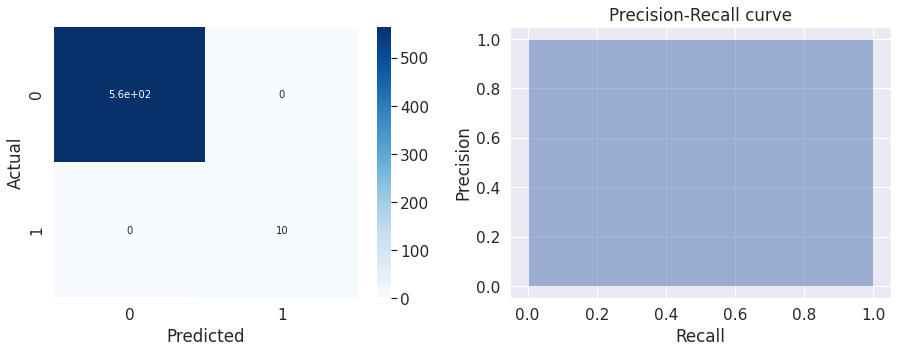

In [ ]:
shuffle_in_unison(data[0],data[1])
y_pred = loaded_model.predict(data[0])
model_evaluation(data[1] , y_pred[1][:][:,1])

In [ ]:
def model_curve(X , Y):

  P , R ,Fb ,S = [] , [] , [] , []
  Th = [0.00 , .05 , .1 , .15 , .2 , .25 , .3 , .35 , .4 , .45 , .5 , .55 , .6 , .65 , .7 , .77 , .8 , .85 , .9 , .95 , 1]
  y_pred = loaded_model.predict(X)
  Y_pred = y_pred[1][:][:,1]
  pred = np.empty((1,len(Y_pred)), dtype=object)

  for i in range(len(Th)):

    pred = np.where(Y_pred>=Th[i], 1, 0)
    Y = np.reshape(Y,len(Y))
    pred = np.reshape(pred,len(pred))

    matrix = confusion_matrix(Y, pred)
    TN = matrix[0][0]
    FP = matrix[0][1]
    specificity = TN / ( TN + FP )
    S.append(specificity)
    P.append(precision_score(Y , pred))
    R.append(recall_score(Y, pred))
    Fb.append(fbeta_score(Y, pred, 2))

  plt.figure(figsize = (7,5))

  plt.ylabel("Magnitudes")
  plt.xlabel("Threshold")
  plt.title("Metrics Graph")

  plt.plot(Th, R, color='b', label='Recall')
  plt.plot(Th, S, color='r', label='specificity')
  plt.plot(Th, Fb, color='g', label='F-beta')
  plt.legend()
  plt.show()
  return P , R , Fb ,Th

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


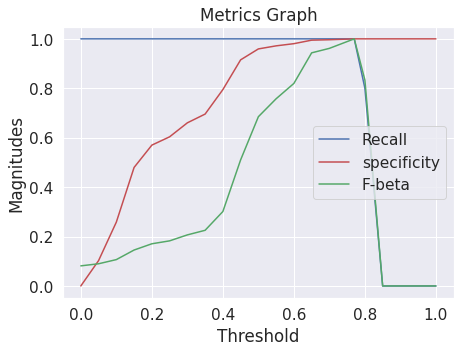

In [ ]:
P , R , Fb , Th = model_curve(data[0] , data[1])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


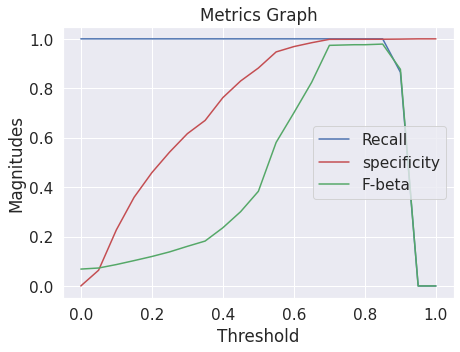

In [ ]:
P , R , Fb , Th = model_curve(dataset[0] , dataset[1])